# **CAT - 04) Regresión Poisson**
Para modelar conteos se utiliza la regresión Poisson, con la siguiente función de probabilidad. Donde, $\mu$ representa la media de ocurrencias del evento de interés. Note que f(y) representa la probabilidad de que ocurran $y$ eventos cuando el fenómeno ocurre con una media de $\mu$ eventos.

$$f(y)=\frac{\mu^y \; e^{-\mu}}{y!}$$

Esta función se caracteriza porque:

$$E(Y) = \mu \quad;\quad Var(Y)=\mu$$

A menudo, la función Poisson se representa a través de una tasa media de ocurrencia $(\theta)$, donde $\mu = \theta n$, con $n$ igual al nivel de exposición.

Los modelos de regresión Poisson también son utilizados para el caso de modelos log-lineales. Sin embargo, en este *notebook* solo se consideran aquellos donde el nivel de exposición es distinto y en el que las variables explicativas son categóricas o continuas.

El modelo de regresión Poisson es un caso de GLM, con la forma:

$$ ln(\mu_i) = ln(n_i) + \boldsymbol{x_i} \; \boldsymbol{\beta} $$

Note que se intenta predecir $\mu_i$ conociendo el nivel de exposición específico para la obervación $i$. A $ln(n_i)$ se le conocer como \texti{offset}.

## **4.1) Definir datos**

Los datos corresponden a una compañía de seguros de autos. Las variables son:
- *District:* Tipo de zona habitacional de los asegurados
- *Car size:* Tamaño del carro del asegurado
- *Age:* Edad del asegurado
- *Holders:* Número de asegurados (variable de exposición)
- *Claims:* Total de reclamos a la aseguradora (variable de respuesta)

In [131]:
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chi2
import rpy2.robjects as robjects
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri
warnings.filterwarnings('ignore')

# Load the Insurance dataset from MASS
robjects.r['library']('MASS')
insurance_data = robjects.r['Insurance']
df_data = pandas2ri.rpy2py_dataframe(insurance_data)

# Change column names
df_data = df_data.rename(columns={"District": "district", "Group": "size",
          "Age": "age", "Holders": "holders", "Claims":"claims"})

# Format district column
df_data["district"] = pd.Categorical(df_data["district"], categories=[1, 2, 3, 4], ordered=True)
aliases = {1: "districtA", 2: "districtB", 3: "districtC", 4: "districtD"}
df_data["district"] = df_data["district"].cat.rename_categories(aliases)

# Format size column
df_data["size"] = pd.Categorical(df_data["size"], categories=[1, 2, 3, 4], ordered=True)
aliases = {1: "small", 2: "medium", 3: "large", 4: "xlarge"}
df_data["size"] = df_data["size"].cat.rename_categories(aliases)

# Format age column
df_data["age"] = pd.Categorical(df_data["age"], categories=[1, 2, 3, 4], ordered=True)
aliases = {1: "<25", 2: "25-30", 3: "30-35", 4: ">35"}
df_data["age"] = df_data["age"].cat.rename_categories(aliases)

# Display dataframe
df_data.sample(5, random_state=1)

,district,size,age,holders,claims
25,districtB,large,<25,66,14
40,districtC,medium,>35,1635,187
53,districtD,medium,<25,31,7
28,districtB,large,>35,1110,143
45,districtC,xlarge,<25,7,3


## **4.2) Modelación de conteos**

Para el anális se tienen las categorías de referencia: *District:* District A | *Size:* Small | *Age:* Less than 25

Recuerde que el modelo tiene la siguiente forma: $ log(\mu) = \beta_o + \beta_1 district + \beta_2 size + \beta_3 age $. Por lo tanto, el "activar" una categoría (o aumentar en 1 unidad una variable continua) tiene un efecto $e^{\beta_j}$ en la tasa que define el conteo esperado de $y_i$. El modelo Poisson tradicional tiene como objetivo cuantificar el conteo, no la tasa de ocurrencia. Por lo tanto, en un modelo sin _offset_ se considera un nivel de exposición "constante".

Los coeficientes de regresión se distribuyen asintóticamente normal. Es posible construir la $Var(\hat{\beta}_j)$. Por lo tanto, para probar la significancia de los parámetros: 

$$ \frac{\hat{\beta}_1}{se(\hat{\beta}_1)} \sim N(0,1) $$

**Conclusiones:**
- A excepción de "Extra Large" todos los coeficientes son significativos, por lo que no se rechaza eliminar alguna variable, ni ninguna categoría.


- En el caso de "Extra Large", se puede intuir que esta categoría no está aportando información al modelo, por lo que los conteos con respecto a "Small" podrían ser los mismos en las dos categorías.


- District A es en el que se hace más reclamaciones al seguro, pues los coeficientes para los demás distritos son negativas. Por ejemplo, para Distrito D se tiene $\beta_j=-1.2815 \; ; \; e^{-1.4437} = 0.0.236$ Por lo que en el Distrito D se hacen tan solo el 23.6% de las reclamaciones que se hacen en el A.


- En la variable edad se observa que los menores de 25 años son, en realidad, los que menos reclamaciones hacen. En comparación con una persona mayor a 35 años se tiene que los más grandes hacen $e^{2.1992}=9.017$. por lo que hacen 9 veces más reclamaciones que los jóvenes.

In [132]:
# Define variables by its role in the model
response = ["claims"]
predictors = ["district", "size", "age"]
exposure = ["holders"]

# Define data for regressions
y = df_data[response]
X = pd.get_dummies(df_data[predictors], columns=predictors, drop_first=True).astype(int)
X = sm.add_constant(X)

# Fit GLM with Poisson distribution
model = sm.GLM(y, X, family=sm.families.Poisson()).fit(method="newton")
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 claims   No. Observations:                   64
Model:                            GLM   Df Residuals:                       54
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -219.32
Date:                Wed, 18 Sep 2024   Deviance:                       121.31
Time:                        16:40:24   Pearson chi2:                     125.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.8431      0

## **4.3) Bondad de ajuste y análisis de residuales**

Recuerde que la regresión Poisson modela la media esperada para el predictor lineal, entonces:
$$ \mu_i = e_i = n_i \; e^{beta_0 +beta_1 + ... + \beta_k } $$

Por lo tanto, los residuales en un modelo Poisson son de la forma $y_i - \hat{y}_i$. Los residuales de Pearson se definen al estandarizar por el valor esperado (debajo), estos tienen una distribución asintóticamente normal $N(0,1)$. Por lo tanto, la suma de sus cuadrados siguen una distribucón $\chi^2$.

Esta prueba se utiliza para evaluar la bondad de ajuste del modelo. $H_0$: El modelo se ajusta bien a los datos observados. $H_a$: El modelo NO se ajusta bien a los datos observados. El p-valor es la probabilidad de observar $H_0$, por lo tanto, si $p-value < \alpha$ se rechaza $H_0$

$$r_i^P = \frac{o_i-e_i}{\sqrt{e_i}} \qquad ; \qquad \sum^n_{i=1} = {r_i^P}^2 = \sum^n_{i=1} \frac{(o_i - e_i)^2}{e_i} \sim \chi^2_{(n-p)}$$

Otra forma de definir los residuales es mediante los *residuales estandarizados*, con la forma que se muestra debajo. Note que se construyen a partir de los residuales de Pearson, simplemente están ajustados por su desviación estándar estimada, a través de la matris *Hat*, donde $h_i$ es el i-ésimo elemento de la diagonal de la matriz $H = X(X^TX)^{-1}X^T$.

$$r^S_i = \frac{r_i^P}{\sqrt{1-h_i}}$$

La devianza, por otro lado, indica que el modelo es significativo, que las variables seleccionadas en realidad sí explican la variabilidad de la respuesta. Para hacer la prueba de devianza se toma como referencia la devianza nula $D_0$, en la cual solo se toma el intercepto como medida explicativa. La hipótesis nila $H_0$ indica que $(D_0 = D_{modelo}$, por lo que un *p-value* indica que existe significancia en el modelo.

$$D_0 - D_{modelo} \sim \chi^2_{k}$$

**Conclusiones:**
- El modelo no pasa la prueba $\chi^2$, por lo que se habla de una carencia de ajuste o algún problema de sobredispersión o exceso de ceros. Más adelante se abordan esas cuestiones.


- Note que el modelo si cumple la prueba de devianza, pero no la de $\chi^2$ con los residuales de Pearson. Esto es debido a que no están midiendo el mismo fenómeno y que la de Pearson es más susceptible a valores atípicos.


- En la gráfica de residuales estandarizados se espera que los puntos se encuentren alrededor del 0. Aquellos con un valor absoluto mayor a 1.96 tienen un 5% de probabilidad de no haber ocurrdio (cuantiles de la normal), por lo que se dice que son valores atípicos y que revelan falta de ajuste en el modelo.


- Para el análisis de observaciones influyentes también se usan los residuales estandarizados. Observaciones con valores mayores a un cuantil de normal con una confianza dada son consideradas influyentes en el modelo.


Residuales de Pearson - Prueba de bondad de ajuste.

Grados de libertad: 54
Estadístico Chi2:   125.17
p-value:            0.00000

Por lo tanto, el modelo NO ajusta bien a los datos observados.
 

Devianza - Prueba de significancia.

Grados de libertad:        54
Diferencia de devianzas:   4115.37
p-value:                   0.00000

Por lo tanto, las variables seleccionadas sí son significativas para el modelo.
sin que logren formar un modelo estadísticamente significativo.
 


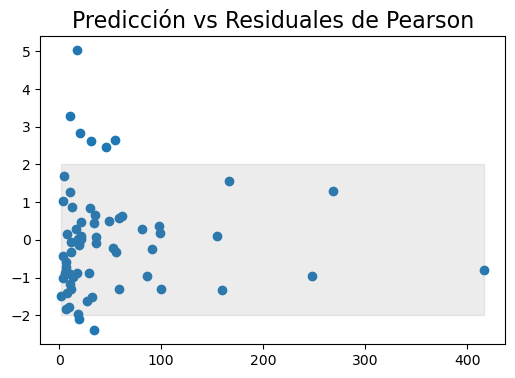

In [133]:
# CLassic residuals
predicted = model.fittedvalues
residuals = df_data["claims"] - predicted

# Pearson residuals
residuals_P = residuals / predicted**0.5

# Pearson residuals goodness of fit test
chi2_stat_p = (residuals_P**2).sum()
pvalue_p = 1 - chi2.cdf(chi2_stat_p, model.df_resid)

# Deviance significance
chi2_stat_d = model.null_deviance - model.deviance
pvalue_d = 1 - chi2.cdf(chi2_stat_d, model.df_model)

# Standardized residuals
h = np.diag(X.values @ np.linalg.inv(X.T @ X) @ X.values.T)
residuals_S = residuals_P / (1-h)**0.5

# Print goodnes of fit test
print("="*100,"\n"+
"""
Residuales de Pearson - Prueba de bondad de ajuste.

Grados de libertad: {}
Estadístico Chi2:   {:.2f}
p-value:            {:.5f}

Por lo tanto, el modelo NO ajusta bien a los datos observados.
""".format(model.df_resid, chi2_stat_p, pvalue_p), "\n"+"="*100)

# Print significance test
print(
"""
Devianza - Prueba de significancia.

Grados de libertad:        {}
Diferencia de devianzas:   {:.2f}
p-value:                   {:.5f}

Por lo tanto, las variables seleccionadas sí son significativas para el modelo.
sin que logren formar un modelo estadísticamente significativo.
""".format(model.df_resid, chi2_stat_d, pvalue_d), "\n"+"="*100)

# Plot residuals
plt.figure(figsize=(6,4))
x_plot = model.predict(X)
plt.scatter(x_plot, residuals_P)
plt.fill_between(x_plot.sort_values(), y1=-2, y2=2, color="gray", alpha=0.15)
plt.title("Predicción vs Residuales de Pearson", fontsize=16)
plt.show()

## **4.4) Selección de variables**

Una forma de seleccionar variables es utilizar el método *stepwise - forward*, el cual consiste en ir agregando variables al modelo y revisar su aportación en explicar la variabilidad de la respuesta. Se agregan una por una, empezando con el modelo que cuanta únicamente con el intercepto, y se elige la que más devianza reduzca en comparación con el modelo anterior.

**Conclusiones:**

- La variable más significativa en el modelo es age, pues reduce la devianza en mayor medida. A pesar de que las otras no reduzcan tanto la varianza, no quiere decir que no ayuden a explicar el modelo.


- A partir de un solo paso en el método *stepwise* no es posible definir el orden definitivo de importancia de todas las variables, es necesario seleccionar una variable a la vez.

In [134]:
# Used to store deviance differences
deviance_diff = []

# Iterate over predictor variables to adjust single-predictor model
for variable in predictors:

    # Define X matrix to adjut single-variable model
    X_sw = df_data[variable]
    X_sw = pd.get_dummies(df_data[variable], columns=variable, drop_first=True).astype(int)
    X_sw = sm.add_constant(X_sw)
    
    # Adjust model
    model_sw = sm.GLM(y, X_sw, family=sm.families.Poisson()).fit(method="newton")
    
    # Store deviance difference
    deviance_diff += [int(model_sw.null_deviance - model_sw.deviance)]
    
df_results = pd.DataFrame({"Deviance Reduction":deviance_diff}, index=predictors)
df_results.index.name = "Variable"
print("="*100+"\n")
print(df_results)
print("\n"+"="*100)


          Deviance Reduction
Variable                    
district                 803
size                     938
age                     2373



## **4.5) Tratamiento de la sobredispersión**

Cuando los modelos no se ajustan correctamente a los datos se puede deber a dos motivos: 1) El modelo no está correctamente especificad, es decir, que no se tienen las variables predictoras correctas o que existen dependencias no linteales, y 2) que exista sobredispersión en los datos. Para el segundo motivo recuerde que en la distribución Poisson: $E(y) = Var(y) = \mu$. Para los datos observados $E(y) = 49.23 \neq Var(y) = 5064$. Entonces, en el ejemplo existe sobredispersión.

Una regresión Poisson no puede modelar datos con sobredispersión, por lo que se utilizan distribuciones alternas como la _"QuasiPoisson"_ o la _"Binomial Negativa"_, las cuales permiten que la esperanza y la varianza sean distintas en los datos de respuesta.

**Modelo QuasiPoisson:**

Se relaja la suposición de que $E(y) = Var(y)$, por lo que se toma que:

$$Var(y_i \vert \eta_i) = \phi \mu_i$$

Para este modelo se requiere una estimación previa de $\phi$, por lo que se propone el estimador debajo. Note que en realidad se trata de un ajuste del estadístico de prueba $\chi^2$ con residuales de Pearson.

$$ \hat{\phi} = \frac{n}{n-p} \sum^n_{i=1} \frac{(y_i - \hat{\mu}_i)^2}{\hat{\mu}_i} = \dfrac{1}{n-p} \sum^n_{i=1} {(r_i^P)}^2 $$

El modelo _Quassi Poisson_ tiene los mismos coeficientes que el modelo Poisson, pero la inferencia $(\mu_i)$  se ajusta por la sobredipersión. Los $se(\beta_j)$ se ajustan por $\hat{\phi}^{0.5}$.

**Modelo Binomial Negativa:**

La distribución Binomial Negativa mide el número de ensayos antes de tener el *r-ésimo* éxito es de la forma:

$$ Sea\; X \sim BN(r, \theta) \quad entonces\quad P(X=x;r,\theta) = \binom{x-1}{r-1} \theta^r (1-\theta)^{x-r}$$

Observe que $x=r,r+1,...$, por lo que se toma la variable, donde $Y=X-r$, que es el número de fallas antes del $r-ésimo$ éxitp, donde $y=0,1,...$. La nueva variable tiene parámetros:

$$ E(Y) = \frac{r(1-\theta)}{\theta} \quad ; \quad Var(Y) = \frac{r(1-\theta)}{\theta} \frac{1}{\theta}$$


La media y la varianza para cada grupo no es la misma.
La varianza es mucho más alta. Se detecta sobredispersión.
Parámetro de dispersión: 2.32

         mean       var
age                    
<25     14.31    273.96
25-30   25.25    512.20
30-35   28.31    587.43
>35    129.06  10716.86



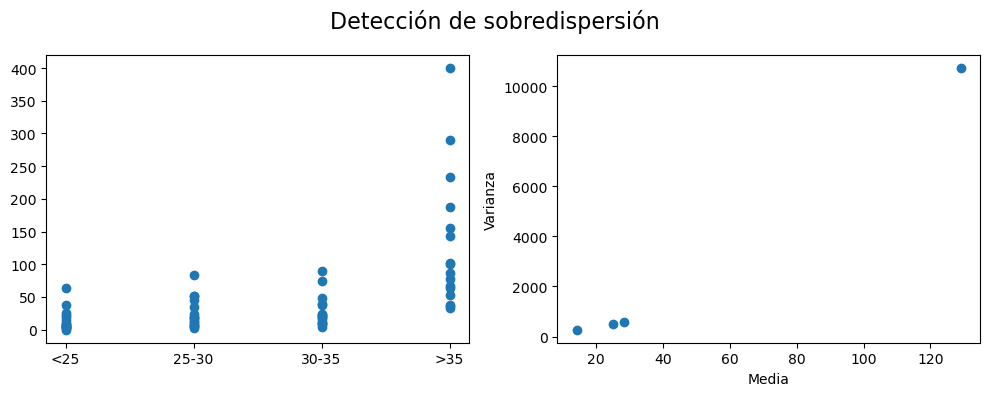


Para el modelo Quassi Poisson. Pearson Chi2 2415.3 p-value: 0.0000
La hipótesis nula es rechazada.
Esto significa que el modelo Quassi Poisson NO se ajusta a los datos


Para el modelo Binomial Negativo. Pearson Chi2 7.7 p-value: 1.0000
La hipótesis nula no puede ser rechazada
Esto significa que el modelo Binomial Negativo SI se ajusta a los datos.



In [135]:
# Compare mean and variance
dispersion_parameter = (residuals_P **2 / model.df_resid).sum()
print("="*100+"\n")
print("La media y la varianza para cada grupo no es la misma.\nLa varianza es mucho más alta. Se detecta sobredispersión.")
print("Parámetro de dispersión: {:.2f}\n".format(dispersion_parameter))
df_grouped = df_data.groupby("age")["claims"].agg(["mean", "var"]).round(2)
print(df_grouped)
print("\n"+"="*100)

# Detect over dispersion for age groups
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.scatter(df_data["age"], df_data["claims"])
ax2.scatter(df_grouped["mean"], df_grouped["var"])
plt.xlabel("Media")
plt.ylabel("Varianza")
plt.suptitle("Detección de sobredispersión", fontsize=16)
plt.tight_layout()
plt.show()

# Fit quasi-poisson model by adjusting the predictions by the dispersion parameter
predicted_qp = predicted * dispersion_parameter
residuals_qp = df_data["claims"] - predicted_qp
residuals_qp_P = residuals_qp / predicted_qp**0.5
qp_P_chi2 = (residuals_qp_P**2).sum()
pvalue_qp_P = 1 - chi2.cdf(qp_P_chi2, model.df_resid)

# Print quassi Poisson results
print("="*100+"\n\nPara el modelo Quassi Poisson. Pearson Chi2 {:.1f} p-value: {:.4f}".format(qp_P_chi2, pvalue_qp_P))
print("La hipótesis nula es rechazada.")
print("Esto significa que el modelo Quassi Poisson NO se ajusta a los datos\n")
print("="*100)

# Fit the negative binomial model
model_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit(method="newton")
nb_P_chi2 = model_nb.pearson_chi2
pvalue_nb_P = 1 - chi2.cdf(nb_P_chi2, model_nb.df_resid)

# Print negative binomial results
print("="*100+"\n\nPara el modelo Binomial Negativo. Pearson Chi2 {:.1f} p-value: {:.4f}".format(nb_P_chi2, pvalue_nb_P))
print("La hipótesis nula no puede ser rechazada")
print("Esto significa que el modelo Binomial Negativo SI se ajusta a los datos.\n")
print("="*100)

## **4.6) Modelación de tasas**

Ahora es de interés conocer la tasa de incidencia para el modelo. Recuerde que:

$$\mu_i = {n}_i \theta_i$$.

Para utilizar el modelo Poisson se debe de tener un modelo de la forma $log(y) = \eta$, por lo tanto, se reescribe $y_i=\theta_i n_i$ y despejando se tiene que;

$$log(y_i) = log(n_i) + \eta_i$$

Recuered que lo que se está modelando al incluir un offset es $\theta_i$, a pesar de que no se muestre explícitamente. Es la única forma de inlcuir la información del nivel de exposición en el modelo, de lo contrario no se podría considerar y los coeficientes podrían no ser significativos en caso de que verdaderamente lo sean.

Entonces, se busca conocer cuál es el Rate Ratio con una categoría frente a otra. El análisis de los coeficientes también se extiende al caso de variables continuas, al conocer el RR de aumentar en 1 unidad, manteniendo todo lo demás constante.

$$ RR = e^{\beta_j} $$

Conclusiones:
- Los coeficientes relacionados con el distrito B y C  no son significativos, por lo que no podemos asegurar que su tasa de incidencia sea distinta a la del distrto A (de referencia).


- En el caso de personas <25 y 25-30, su coeficiente de regresión es medianamente significativo, por lo que no hay mucha evidencia de que realmente sean distintas las tasas de incidencia entre las personas en sus 20s.


- Se observa que los coeficientes para Distrito ahora son positivos y ascendentes, esto quiere decir que al comparar el distrito A con el D, $RR=e^{0.2342}=1.263$, en el distrito D se tiene más incidencia de reclamaciones, aunque el número total sea menor.


- El mismo efecto sucede con la edad, pues al comparar los menores de 25 años con los mayores de 35, el coeficiente de interacción es $\beta_j = 0.5367 \; ; \; e^{-0.5367} = 0.584$, lo que quiere decir que las personas mayores tienen 41% menos probabilidad de hacer una reclamación que las más jóvenes.

In [136]:
# Offset variable
offset = np.log(df_data[exposure])

# Fit the Poisson regression model with an offset
model_rate = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset.values[:,0]).fit()

# Display the summary of the model
print(model_rate.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 claims   No. Observations:                   64
Model:                            GLM   Df Residuals:                       54
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -184.37
Date:                Wed, 18 Sep 2024   Deviance:                       51.420
Time:                        16:40:24   Pearson chi2:                     48.6
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9443
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.8217      0

## **4.7) Exceso de ceros**

La distribución Poisson sirve para modelar casos con 0 ocurrencias. Sin embargo, algunas bases de datos tienen un _excesio de ceros_, es decir, que el número de ceros observados excede el número esperado por la distribución Poisson. Para lidiar con este problema se utiliza un modelo ZIP (_zero inflated poisson_) que consiste en modelar por separado la probabilidad de que una observación sea $0$ o no; en caso de que no, se utiliza el modelo de regresión Poisson. El modelo ZIP es de la forma:

$$P(y_i=0) = \phi_i (1-\phi_i)e^{-\lambda_i} \quad;\quad k=0$$

$$P(y_i=k) = (1-\phi_i) \dfrac{e^{-\lambda_i}\lambda_i^k}{k!}$$

Observe que además de $\lambda_i = \eta_i$ se tiene que estimar $\phi_i$, que representa el exceso de ceros en la muestra. Una forma de hacerlo es definirlo de acuerdo con el número de ceros en la muestra, mientras que una forma más sofisticada es ajustar un modelo binomial y calcular cada $\phi_i$ con la información de la observación _i_.

**Notas:**
- El modelo ZIP es básicamente combinar un modelo logístico con uno Poisson.
- Además de modelos ZIP, también se pueden utilizar modelos Hurdle.


Modelo Poisson regular
Pearson Chi2: 2527.57 p.value: 1.00 
Por lo tanto, el modelo NO ajusta bien al modelo 


Modelo Binomial Negativo
Pearson Chi2: 761.22 p.value: 1.00 
Por lo tanto, el modelo NO ajusta bien al modelo 



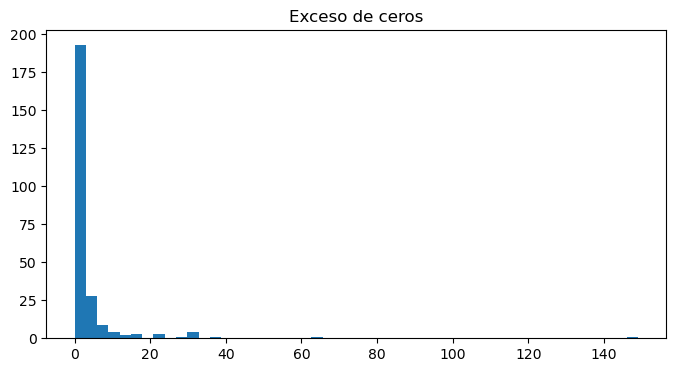

         Current function value: 2.849651
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              fish_count   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            4
Date:                 Wed, 18 Sep 2024   Pseudo R-squ.:                  0.3679
Time:                         16:52:35   Log-Likelihood:                -712.41
converged:                       False   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                3.595e-178
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_const         0.9145      1.163      0.786      0.432      -1.366       3.195
inflate_live_bait     0.6647      1.073      0.620      0.535      -1.438       2.767
inflate_camper       -0.8718      0.369     -2.360      0.018      -1.596      -0.148
inflate_persons      -0.9335      0.210     -4.456      0.000      -1.344      -0.523
inflate_children      1.9598      0.343      5.706      0.000       1.287       2.633
const                -2.4412      0.275     -8.874      0.000      -2.980      -1.902
live_bait             1.8094      0.241      7.496      0.000       1.336       2.282
camper                0.5965      0.092      6.456      0.000       0.415       0.778
persons               0.8361      0.042     19.797      0.000       0.753       0.919
children             -1.1802      0.091    -12.962      0.000      -1.359      -1.002
=====================================================================================
"""

In [154]:
df_data_zip = pd.DataFrame({"live_bait":[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
                            "camper": [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
                            "persons": [1, 1, 1, 2, 1, 4, 3, 4, 3, 1, 4, 3, 3, 3, 1, 1, 4, 3, 2, 3, 4, 4, 2, 2, 3, 2, 4, 2, 1, 4, 1, 3, 4, 4, 1, 2, 2, 4, 3, 4, 1, 4, 3, 4, 4, 1, 2, 1, 2, 2, 2, 2, 4, 2, 3, 1, 1, 1, 4, 1, 2, 2, 2, 4, 4, 1, 1, 3, 1, 2, 3, 4, 4, 3, 1, 2, 3, 1, 2, 4, 4, 2, 3, 1, 1, 3, 4, 1, 4, 3, 3, 2, 3, 2, 4, 3, 4, 4, 2, 4, 1, 2, 4, 3, 2, 4, 1, 3, 4, 4, 1, 2, 1, 4, 3, 2, 2, 4, 3, 3, 2, 1, 4, 1, 4, 4, 1, 3, 2, 4, 3, 1, 4, 4, 2, 4, 4, 3, 2, 2, 4, 2, 3, 3, 1, 2, 4, 3, 3, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 4, 3, 1, 3, 4, 4, 1, 4, 3, 3, 4, 3, 2, 4, 2, 4, 2, 2, 1, 2, 1, 3, 2, 2, 2, 3, 4, 3, 3, 4, 2, 3, 1, 1, 1, 2, 2, 1, 3, 4, 2, 2, 2, 1, 2, 4, 3, 4, 4, 1, 1, 1, 1, 1, 2, 4, 2, 4, 3, 4, 4, 4, 3, 2, 1, 2, 2, 3, 1, 3, 2, 1, 4, 3, 2, 2, 1, 2, 1, 3, 2, 2, 4, 2, 3, 3, 2, 4, 2, 3, 2],
                            "children": [0, 0, 0, 1, 0, 2, 1, 3, 2, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 2, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 3, 0, 0, 2, 0, 1, 0, 3, 2, 2, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 1, 1, 2, 1, 0, 3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 3, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 2, 3, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 2, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 3, 1, 2, 1],
                            "fish_count": [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 0, 1, 5, 0, 3, 30, 0, 13, 0, 0, 0, 0, 0, 11, 5, 0, 1, 1, 7, 0, 14, 0, 32, 0, 1, 0, 0, 0, 1, 5, 0, 1, 0, 22, 0, 15, 0, 0, 0, 5, 4, 2, 0, 2, 32, 0, 0, 1, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 5, 0, 2, 1, 0, 1, 149, 0, 1, 0, 0, 1, 0, 0, 0, 2, 2, 29, 3, 0, 0, 5, 0, 0, 0, 0, 0, 1, 7, 1, 0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 4, 3, 3, 8, 2, 1, 6, 0, 0, 5, 3, 31, 0, 2, 0, 0, 0, 0, 0, 0, 6, 9, 0, 0, 0, 0, 0, 2, 15, 1, 2, 3, 0, 65, 5, 0, 0, 0, 0, 1, 8, 0, 0, 0, 2, 4, 5, 9, 0, 0, 0, 0, 21, 0, 6, 0, 0, 0, 0, 16, 0, 0, 4, 2, 10, 0, 0, 0, 2, 1, 3, 0, 0, 21, 0, 0, 2, 0, 3, 0, 38, 0, 0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 5, 0, 0, 2, 0, 0, 0, 1, 4, 0, 0, 2, 3, 0, 0, 0, 0, 1, 2, 0, 6, 4, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]})

# Define data for regressions
y_zip = df_data_zip["fish_count"]
X_zip = sm.add_constant(df_data_zip.drop(["fish_count"],axis=1))

# Fit GLM with Poisson distribution
model_zip = sm.GLM(y_zip, X_zip, family=sm.families.Poisson()).fit(method="newton")
print("="*100+"\n\n"+"Modelo Poisson regular\nPearson Chi2: {:.2f} p.value: {:.2f}".format(
    model_zip.pearson_chi2, chi2.cdf(model_zip.pearson_chi2, df=model_zip.df_resid)),
      "\nPor lo tanto, el modelo NO ajusta bien al modelo", "\n\n"+"="*100)

# Fit GLM with Negative Binomial distribution
model_zip = sm.GLM(y_zip, X_zip, family=sm.families.NegativeBinomial()).fit(method="newton")
print("="*100+"\n\n"+"Modelo Binomial Negativo\nPearson Chi2: {:.2f} p.value: {:.2f}".format(
    model_zip.pearson_chi2, chi2.cdf(model_zip.pearson_chi2, df=model_zip.df_resid)),
      "\nPor lo tanto, el modelo NO ajusta bien al modelo", "\n\n"+"="*100)

# Plot excess of zeros
plt.figure(figsize=(8,4))
plt.hist(df_data_zip["fish_count"], bins=50)
plt.title("Exceso de ceros")
plt.show()

# Print summary of adjusted model
sm.ZeroInflatedPoisson(endog=y_zip, exog=X_zip, exog_infl=X_zip, inflation='logit').fit().summary()